In [1]:
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import tqdm
torch.manual_seed(0);
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import default_collate
import torchinfo
import matplotlib.pyplot as plt
import time

In [2]:
variable = []
target = []
mat = scipy.io.loadmat('OQC.mat')

In [3]:
dataset = pd.DataFrame(mat.get('data'))
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2952 non-null   float64
 1   1       2952 non-null   float64
 2   2       2952 non-null   float64
 3   3       2952 non-null   float64
 4   4       2952 non-null   float64
 5   5       2952 non-null   float64
 6   6       2952 non-null   float64
 7   7       2952 non-null   float64
 8   8       2952 non-null   float64
 9   9       2952 non-null   float64
 10  10      2952 non-null   float64
 11  11      2952 non-null   float64
 12  12      2952 non-null   float64
 13  13      2952 non-null   float64
 14  14      2952 non-null   float64
 15  15      2952 non-null   float64
 16  16      2952 non-null   float64
 17  17      2952 non-null   float64
 18  18      2952 non-null   float64
 19  19      2952 non-null   float64
 20  20      2952 non-null   float64
 21  21      2952 non-null   float64
 22  

In [4]:
features = dataset.iloc[:, :-1].values
label = dataset.iloc[:, -1].values
features.shape, label.shape

((2952, 48), (2952,))

In [5]:
features = torch.tensor(features).float()## Convert to tensor
label = torch.tensor(label).long()

In [6]:
data_train, data_test, labels_train, labels_test = train_test_split(features, label, test_size= 0.30, random_state=42)

In [7]:
train_ds = []
val_ds = []

for i in range(len(data_train)):
    train_ds.append((data_train[i],labels_train[i]))
    
for j in range(len(data_test)):
    val_ds.append((data_test[j],labels_test[j]))   
    

In [8]:
input_size = len(data_train[0])
num_classes = len(np.unique(label))
input_size, num_classes

(48, 3)

In [9]:
for a,b in DataLoader(val_ds, 1,shuffle=True):
    print(a)
    print(b)
    break

tensor([[8.8184e-01, 1.2705e-01, 3.9810e-01, 1.7693e-03, 4.4444e-01, 6.6667e-01,
         4.4444e-01, 5.7143e-01, 2.5000e-01, 5.7143e-01, 2.5000e-01, 2.5000e-01,
         3.3187e-01, 9.9439e-01, 8.3245e-01, 6.3636e-01, 3.7500e-01, 3.7500e-01,
         5.0000e-01, 3.3333e-01, 5.0000e-01, 7.4074e-02, 3.0623e-01, 3.3333e-01,
         5.0000e-01, 2.6667e-01, 6.9377e-01, 6.1453e-01, 3.8547e-01, 9.2589e-01,
         1.0000e+00, 9.9213e-01, 4.9981e-02, 2.2996e-01, 1.0000e+00, 6.5889e-01,
         4.6657e-01, 6.3312e-01, 5.3298e-02, 8.7946e-01, 9.9608e-01, 9.3067e-02,
         1.0000e+00, 3.7652e-05, 1.2500e-01, 5.7611e-02, 5.7611e-02, 9.2593e-01]])
tensor([1])


## Task 1
You are asked to build a three-layer feed-forward neural network to solve the monitoring problem of injection molding machine. Your implementation must be in Pytorch and executable in Google Colab environments. The proportion of training and testing samples is 70:30 where your model must deliver the smallest testing error possible. In that case, you need to select the number of nodes of hidden layers, the number of epochs, the learning rates, the mini-batch size, etc. that lead to the smallest testing error. In this assignment, you have to use the SGD optimizer as exemplified in the lab materials under the mini-batch update fashion. The evaluation metric here is the classification error. No feature selection is allowed here.

In [10]:
class Three_Layer(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, out_size):
        super().__init__()
        self.linear = nn.Linear(input_size, hidden_size )
        self.linear2 = nn.Linear(hidden_size, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, out_size)
        
        
    def forward(self, xb):
        x = self.linear(xb)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x
    

In [11]:
def accuracy(outputs, labels):
    desc, predictor = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predictor == labels).item() / len(predictor))

In [12]:
def forward_step(model, batch):
    predictor, response = batch 
    out = model.forward(predictor) 
    loss = F.cross_entropy(out, response)
    acc = accuracy(out, response)
    error = 1-acc
    return {'val_loss': loss, 'val_acc': acc, "val_error" : error}

In [13]:
def mean_epoch(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    batch_error = [x['val_error'] for x in outputs]
    epoch_error = torch.stack(batch_error).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(),'val_error': epoch_error.item()}
    

In [14]:
def fit(epochs, lr, model, batch_size = 8, opt_func=torch.optim.SGD):
    
    t_load = DataLoader(train_ds, batch_size, shuffle=True)
    v_load = DataLoader(val_ds, batch_size , shuffle=True)
    
    optimizer = opt_func(model.parameters(), lr)
    val_history = [] # for recording epoch-wise results
    train_history = []
    train_output = []
    total_time = []
    
    
    for epoch in range(epochs):
        start= time.time()
        # Training Phase 
        for batch in t_load:
            output = forward_step(model,batch)
            loss = output['val_loss']
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() ##reset the gradient
            
        train_output = [forward_step(model,t_batch) for t_batch in t_load]
        train_result = mean_epoch(train_output)
        
        val_output = [forward_step(model,v_batch) for v_batch in v_load]
        val_result = mean_epoch(val_output)
        elapsed = time.time()-start
        
        print("""Epoch [{}], Time {:4f},
                val_loss: {:.4f}, loss: {:.4f},
                val_acc: {:.4f}, acc: {:.4f},
                val_err: {:.4f}, err: {:.4f},
                
                """.format(epoch,elapsed,val_result['val_loss'],  train_result['val_loss'], val_result['val_acc'],
                           train_result['val_acc'] , val_result['val_error'], train_result['val_error']))
        
        val_history.append(val_result)
        train_history.append(train_result)
        total_time.append(elapsed)
        

    return [val_history,train_history,total_time]

In [15]:
input_size = len(data_train[0])
num_classes = len(np.unique(label))
hidden_size_1 = 64
hidden_size_2 = 64

input_size, num_classes

(48, 3)

In [16]:
model_layer = Three_Layer(input_size, hidden_size_1, hidden_size_2,out_size = num_classes)
history1 = fit(50, 0.05, model_layer)

Epoch [0], Time 0.328616,
                val_loss: 0.8687, loss: 0.8838,
                val_acc: 0.4482, acc: 0.4450,
                val_err: 0.5518, err: 0.5550,
                
                
Epoch [1], Time 0.321344,
                val_loss: 0.5627, loss: 0.5612,
                val_acc: 0.7553, acc: 0.7582,
                val_err: 0.2447, err: 0.2418,
                
                
Epoch [2], Time 0.295750,
                val_loss: 0.2575, loss: 0.2827,
                val_acc: 0.8915, acc: 0.8687,
                val_err: 0.1085, err: 0.1313,
                
                
Epoch [3], Time 0.317836,
                val_loss: 0.1166, loss: 0.1252,
                val_acc: 0.9625, acc: 0.9575,
                val_err: 0.0375, err: 0.0425,
                
                
Epoch [4], Time 0.351780,
                val_loss: 0.2162, loss: 0.2156,
                val_acc: 0.9369, acc: 0.9329,
                val_err: 0.0631, err: 0.0671,
                
                


Epoch [41], Time 0.307363,
                val_loss: 0.0006, loss: 0.0006,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [42], Time 0.318422,
                val_loss: 0.0006, loss: 0.0006,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [43], Time 0.310481,
                val_loss: 0.0006, loss: 0.0006,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [44], Time 0.296385,
                val_loss: 0.0005, loss: 0.0005,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [45], Time 0.328578,
                val_loss: 0.0005, loss: 0.0005,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

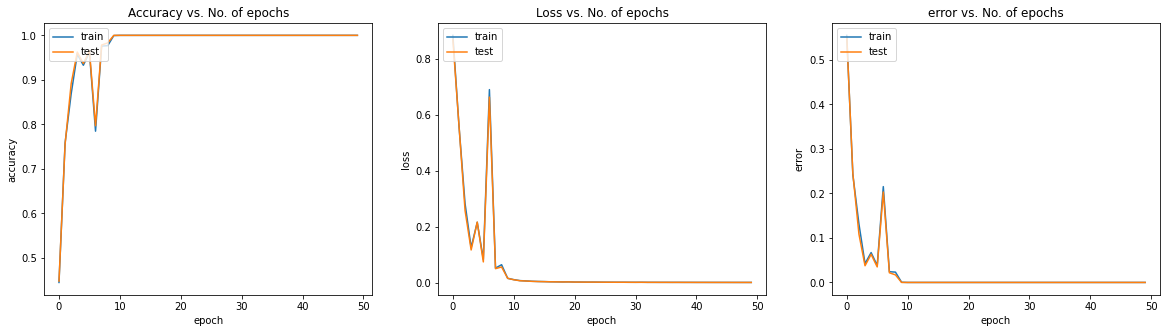

In [17]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 3, figsize=(20,5))



val_history = history1[0]
train_history = history1[1]

val_accuracies = [result['val_acc'] for result in val_history ]
train_accuracies = [result['val_acc'] for result in train_history]

axes[0].plot(train_accuracies, label='Train')
axes[0].plot(val_accuracies, label='Test')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].set_title('Accuracy vs. No. of epochs')
axes[0].legend(['train', 'test'], loc='upper left')


val_loss = [result['val_loss'] for result in val_history ]
train_loss = [result['val_loss'] for result in train_history]

axes[1].plot(train_loss, label='Train')
axes[1].plot(val_loss, label='Test')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].set_title('Loss vs. No. of epochs')
axes[1].legend(['train', 'test'], loc='upper left')

val_error = [result['val_error'] for result in val_history ]
train_error = [result['val_error'] for result in train_history]

axes[2].plot(train_error, label='Train')
axes[2].plot(val_error, label='Test')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('error')
axes[2].set_title('error vs. No. of epochs')
axes[2].legend(['train', 'test'], loc='upper left')

        

In [18]:
average_time = np.mean(history1[2])
print("average time per epoch: {:2f}".format(average_time), "s")

average time per epoch: 0.313519 s


## Task 2

You are asked to study the effect of network structure: hidden nodes, hidden layers to the classification
performance. That is, you try different network configurations and understand the patterns. Your
experiments have to be well-documented in your Jupyter notebook file and your report. It has to cover
different aspects of network configurations such as shallow network, wide network, deep network etc.
[

## Wide vs Narrow Network

To vary the size of neuron in the network: experiment
[4,16,32,64, 128]

In [19]:
def plot(history_model, test, input_list):
    
    f, axes = plt.subplots(len(history_model), 3, figsize=(15,30))
    count = 0
    
    for mod in history_model:
        val_history = mod[0]
        train_history = mod[1]

        val_accuracies = [result['val_acc'] for result in val_history ]
        train_accuracies = [result['val_acc'] for result in train_history]

        axes[count][0].plot(train_accuracies, label='Train')
        axes[count][0].plot(val_accuracies, label='Test')
        axes[count][0].set_xlabel('epoch')
        axes[count][0].set_ylabel('accuracy')
        
        axes[count][0].set_title('Accuracy vs. No. of epochs ' + test + str(input_list[count]))
        axes[count][0].legend(['train', 'test'], loc='upper left')


        val_loss = [result['val_loss'] for result in val_history ]
        train_loss = [result['val_loss'] for result in train_history]

        axes[count][1].plot(train_loss, label='Train')
        axes[count][1].plot(val_loss, label='Test')
        axes[count][1].set_xlabel('epoch')
        axes[count][1].set_ylabel('loss')
        axes[count][1].set_title('Loss vs. No. of epochs ' + test +  str(input_list[count]))
        axes[count][1].legend(['train', 'test'], loc='upper left')
        
        val_error = [result['val_error'] for result in val_history ]
        train_error = [result['val_error'] for result in train_history]

        axes[count][2].plot(train_error, label='Train')
        axes[count][2].plot(val_error, label='Test')
        axes[count][2].set_xlabel('epoch')
        axes[count][2].set_ylabel('error')
        axes[count][2].set_title('error vs. No. of epochs ' + test + str(input_list[count]))
        axes[count][2].legend(['train', 'test'], loc='upper left')

        
        count+=1

In [20]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_list, out_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fcs = nn.ModuleList(hidden_list)
        self.out = nn.Linear(hidden_size, out_size)
        
        
    def forward(self, xb):
        x = self.fc1(xb)
        x = F.relu(x)
        
        for l in self.fcs:
            x = F.relu(l(x))
            
        x = self.out(x)
        return x
    

In [21]:
hidden_size = [8,16,32,64,128,256]
collections = []
input_size = len(data_train[0])
num_classes = len(np.unique(label))

average_epoch_time = []

for i in hidden_size:
    hidden_list = [nn.Linear(i, i)]
    model_layer = Model(input_size, i, hidden_list , out_size = num_classes)
    print(torchinfo.summary(model_layer))
    history_layer = fit(50,.001, model_layer)
    average_epoch_time.append(np.mean(history_layer[2]))
    collections.append(history_layer)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            392
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       72
├─Linear: 1-3                            27
Total params: 491
Trainable params: 491
Non-trainable params: 0
Epoch [0], Time 0.314878,
                val_loss: 1.1331, loss: 1.1413,
                val_acc: 0.3101, acc: 0.2891,
                val_err: 0.6899, err: 0.7109,
                
                
Epoch [1], Time 0.283226,
                val_loss: 1.1208, loss: 1.1271,
                val_acc: 0.3097, acc: 0.2891,
                val_err: 0.6903, err: 0.7109,
                
                
Epoch [2], Time 0.322354,
                val_loss: 1.1126, loss: 1.1175,
                val_acc: 0.3097, acc: 0.2891,
                val_err: 0.6903, err: 0.7109,
                
                
Epoch [3], Time 0.292402,
                val_loss: 1.1072, loss: 

Epoch [38], Time 0.299804,
                val_loss: 1.0891, loss: 1.0848,
                val_acc: 0.4223, acc: 0.3933,
                val_err: 0.5777, err: 0.6067,
                
                
Epoch [39], Time 0.288284,
                val_loss: 1.0887, loss: 1.0850,
                val_acc: 0.4230, acc: 0.3933,
                val_err: 0.5770, err: 0.6067,
                
                
Epoch [40], Time 0.306135,
                val_loss: 1.0883, loss: 1.0842,
                val_acc: 0.4245, acc: 0.3962,
                val_err: 0.5755, err: 0.6038,
                
                
Epoch [41], Time 0.287966,
                val_loss: 1.0877, loss: 1.0834,
                val_acc: 0.4249, acc: 0.3972,
                val_err: 0.5751, err: 0.6028,
                
                
Epoch [42], Time 0.297616,
                val_loss: 1.0871, loss: 1.0835,
                val_acc: 0.4249, acc: 0.3948,
                val_err: 0.5751, err: 0.6052,
                
            

Epoch [26], Time 0.421136,
                val_loss: 1.0878, loss: 1.0835,
                val_acc: 0.4816, acc: 0.4918,
                val_err: 0.5184, err: 0.5082,
                
                
Epoch [27], Time 0.421394,
                val_loss: 1.0871, loss: 1.0827,
                val_acc: 0.4824, acc: 0.4942,
                val_err: 0.5176, err: 0.5058,
                
                
Epoch [28], Time 0.398640,
                val_loss: 1.0865, loss: 1.0817,
                val_acc: 0.4812, acc: 0.4928,
                val_err: 0.5188, err: 0.5072,
                
                
Epoch [29], Time 0.430661,
                val_loss: 1.0856, loss: 1.0810,
                val_acc: 0.4872, acc: 0.4942,
                val_err: 0.5128, err: 0.5058,
                
                
Epoch [30], Time 0.397885,
                val_loss: 1.0847, loss: 1.0801,
                val_acc: 0.4891, acc: 0.4971,
                val_err: 0.5109, err: 0.5029,
                
            

Epoch [14], Time 0.330656,
                val_loss: 1.0747, loss: 1.0695,
                val_acc: 0.5206, acc: 0.5396,
                val_err: 0.4794, err: 0.4604,
                
                
Epoch [15], Time 0.339375,
                val_loss: 1.0727, loss: 1.0670,
                val_acc: 0.5244, acc: 0.5376,
                val_err: 0.4756, err: 0.4624,
                
                
Epoch [16], Time 0.339255,
                val_loss: 1.0701, loss: 1.0644,
                val_acc: 0.5225, acc: 0.5372,
                val_err: 0.4775, err: 0.4628,
                
                
Epoch [17], Time 0.372071,
                val_loss: 1.0673, loss: 1.0612,
                val_acc: 0.5274, acc: 0.5415,
                val_err: 0.4726, err: 0.4585,
                
                
Epoch [18], Time 0.363114,
                val_loss: 1.0646, loss: 1.0585,
                val_acc: 0.5214, acc: 0.5410,
                val_err: 0.4786, err: 0.4590,
                
            

Epoch [2], Time 0.388561,
                val_loss: 1.0905, loss: 1.0883,
                val_acc: 0.4321, acc: 0.4638,
                val_err: 0.5679, err: 0.5362,
                
                
Epoch [3], Time 0.374822,
                val_loss: 1.0884, loss: 1.0858,
                val_acc: 0.5101, acc: 0.5319,
                val_err: 0.4899, err: 0.4681,
                
                
Epoch [4], Time 0.353636,
                val_loss: 1.0864, loss: 1.0835,
                val_acc: 0.5169, acc: 0.5483,
                val_err: 0.4831, err: 0.4517,
                
                
Epoch [5], Time 0.345053,
                val_loss: 1.0847, loss: 1.0815,
                val_acc: 0.5259, acc: 0.5545,
                val_err: 0.4741, err: 0.4455,
                
                
Epoch [6], Time 0.351303,
                val_loss: 1.0829, loss: 1.0793,
                val_acc: 0.5308, acc: 0.5574,
                val_err: 0.4692, err: 0.4426,
                
                


Epoch [43], Time 0.344908,
                val_loss: 0.6490, loss: 0.6394,
                val_acc: 0.8758, acc: 0.8692,
                val_err: 0.1242, err: 0.1308,
                
                
Epoch [44], Time 0.389194,
                val_loss: 0.6291, loss: 0.6189,
                val_acc: 0.8735, acc: 0.8692,
                val_err: 0.1265, err: 0.1308,
                
                
Epoch [45], Time 0.417748,
                val_loss: 0.6035, loss: 0.5948,
                val_acc: 0.8964, acc: 0.8871,
                val_err: 0.1036, err: 0.1129,
                
                
Epoch [46], Time 0.424860,
                val_loss: 0.5827, loss: 0.5755,
                val_acc: 0.8859, acc: 0.8813,
                val_err: 0.1141, err: 0.1187,
                
                
Epoch [47], Time 0.419174,
                val_loss: 0.5628, loss: 0.5559,
                val_acc: 0.8926, acc: 0.8847,
                val_err: 0.1074, err: 0.1153,
                
            

Epoch [31], Time 0.506802,
                val_loss: 0.8510, loss: 0.8394,
                val_acc: 0.7620, acc: 0.7814,
                val_err: 0.2380, err: 0.2186,
                
                
Epoch [32], Time 0.558746,
                val_loss: 0.8278, loss: 0.8152,
                val_acc: 0.8037, acc: 0.8166,
                val_err: 0.1963, err: 0.1834,
                
                
Epoch [33], Time 0.519826,
                val_loss: 0.8047, loss: 0.7921,
                val_acc: 0.8157, acc: 0.8277,
                val_err: 0.1843, err: 0.1723,
                
                
Epoch [34], Time 0.417995,
                val_loss: 0.7802, loss: 0.7674,
                val_acc: 0.8315, acc: 0.8403,
                val_err: 0.1685, err: 0.1597,
                
                
Epoch [35], Time 0.449127,
                val_loss: 0.7562, loss: 0.7432,
                val_acc: 0.8529, acc: 0.8547,
                val_err: 0.1471, err: 0.1453,
                
            

Epoch [19], Time 0.468127,
                val_loss: 0.9173, loss: 0.9066,
                val_acc: 0.7226, acc: 0.7370,
                val_err: 0.2774, err: 0.2630,
                
                
Epoch [20], Time 0.481461,
                val_loss: 0.8962, loss: 0.8854,
                val_acc: 0.7481, acc: 0.7563,
                val_err: 0.2519, err: 0.2437,
                
                
Epoch [21], Time 0.480489,
                val_loss: 0.8729, loss: 0.8626,
                val_acc: 0.7917, acc: 0.7987,
                val_err: 0.2083, err: 0.2013,
                
                
Epoch [22], Time 0.472139,
                val_loss: 0.8479, loss: 0.8392,
                val_acc: 0.8480, acc: 0.8441,
                val_err: 0.1520, err: 0.1559,
                
                
Epoch [23], Time 0.488489,
                val_loss: 0.8230, loss: 0.8139,
                val_acc: 0.8649, acc: 0.8581,
                val_err: 0.1351, err: 0.1419,
                
            

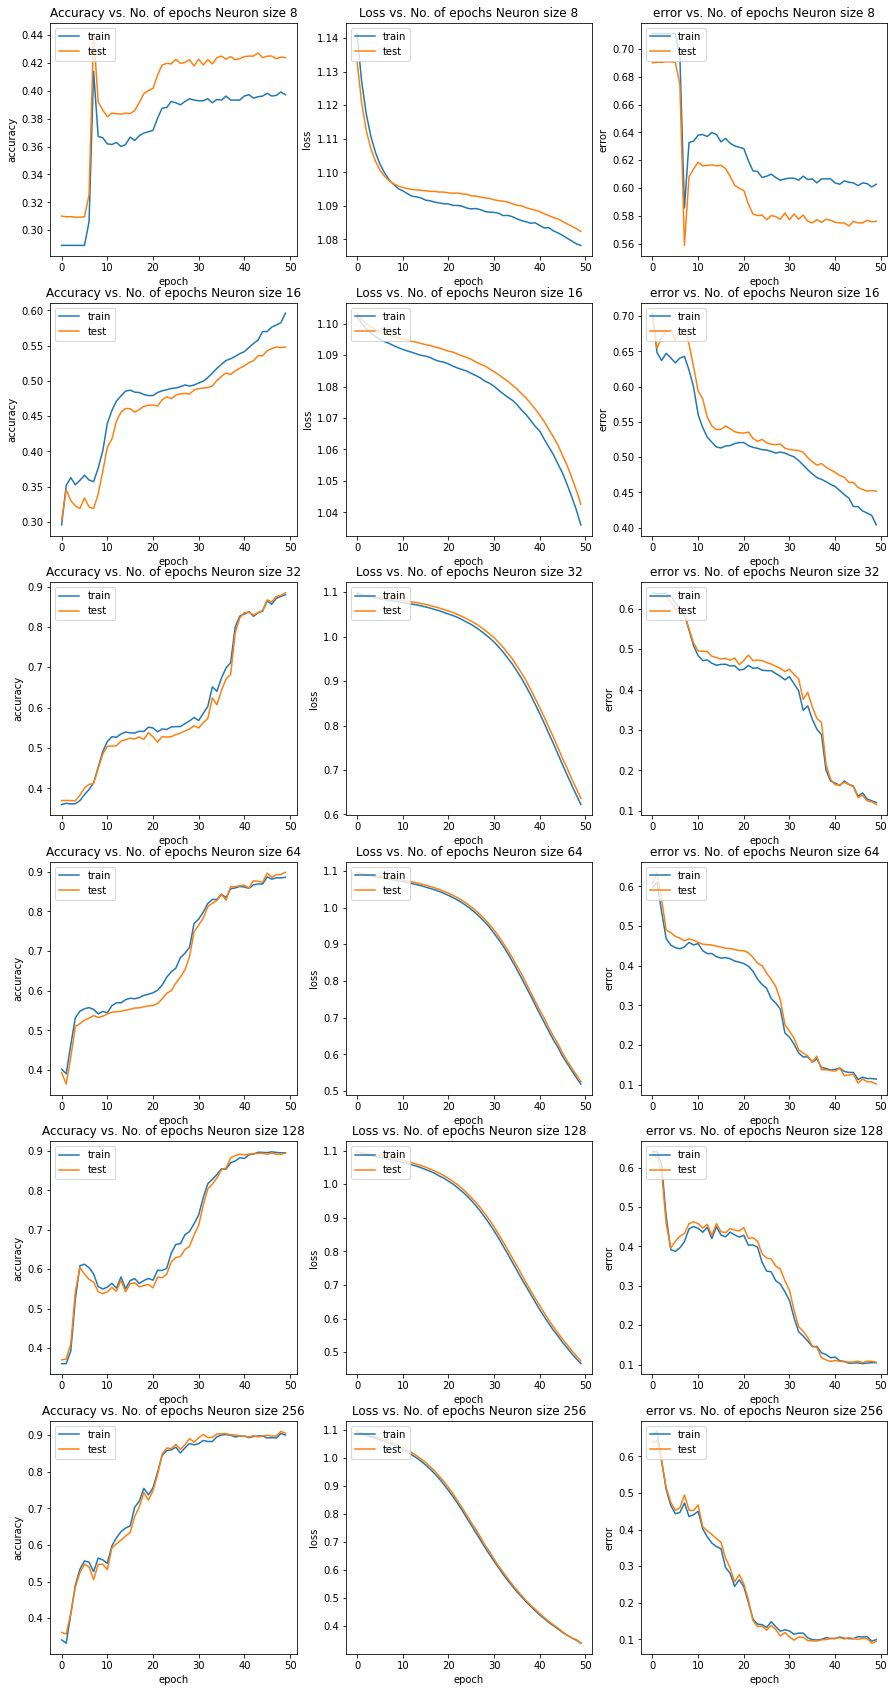

In [22]:
plot(collections, "Neuron size ", hidden_size)

In [23]:
def plot_time(input_list,collections, label):
    
    mean_time = [np.mean(i[2]) for i in collections]
    plt.plot(input_list, mean_time)
    plt.ylabel('time')
    plt.xlabel(label)
    
    plt.show()

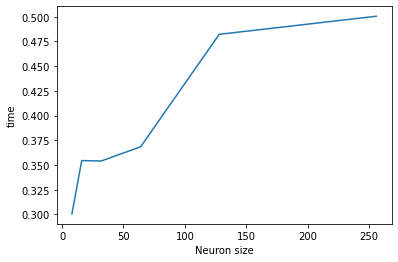

In [24]:
plot_time(hidden_size, collections, "Neuron size")

In [25]:
def error_statistics(name, label, collections):
    min_error = []
    min_error_index = []
    for i in collections:
        error = []
        for j in i[0]:
            error.append(j['val_error'])
        min_index = np.argmin(error)
        min_error_index.append(min_index)
        min_error.append(error[min_index])

    data = {name: label, "minimum error": min_error, "epoch": min_error_index}
    df = pd.DataFrame(data)
    return df

In [26]:
error_statistics("Neuron Size", hidden_size , collections)

,Neuron Size,minimum error,epoch
0,8,0.558934,7
1,16,0.451952,47
2,32,0.115240,49
3,64,0.101351,49
4,128,0.105105,46
5,256,0.089715,48


Batch size 128 and 256 seems to produce the lowest error within 50 epochs, the divergence between training dataset seems to be the smallest amongst all the other neuron sizes. 

Conclude that a wider network produce a smaller training and test error, hence a wide network is better for this scenerio.

Will be selecting batch 128 as the error rate is similar to neuron size 256 but the time taken for trainin per epoch is lesser

## Deep vs Shallow Network

In [27]:
hidden_size = 64
collections = []
input_size = len(data_train[0])
num_classes = len(np.unique(label))
hidden_list = []

average_epoch_time = []

for i in range(6):
    hidden_list.append(nn.Linear(hidden_size, hidden_size))
    model_layer = Model(input_size, hidden_size, hidden_list , out_size = num_classes)
    print(torchinfo.summary(model_layer))
    history_layer = fit(50,.001, model_layer)
    average_epoch_time.append(np.mean(history_layer[2]))
    collections.append(history_layer)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            3,136
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       4,160
├─Linear: 1-3                            195
Total params: 7,491
Trainable params: 7,491
Non-trainable params: 0
Epoch [0], Time 0.349656,
                val_loss: 1.1009, loss: 1.0931,
                val_acc: 0.3209, acc: 0.3523,
                val_err: 0.6791, err: 0.6477,
                
                
Epoch [1], Time 0.407269,
                val_loss: 1.0971, loss: 1.0905,
                val_acc: 0.3221, acc: 0.3557,
                val_err: 0.6779, err: 0.6443,
                
                
Epoch [2], Time 0.351162,
                val_loss: 1.0937, loss: 1.0878,
                val_acc: 0.3544, acc: 0.3740,
                val_err: 0.6456, err: 0.6260,
                
                
Epoch [3], Time 0.454440,
                val_loss: 1.09

Epoch [38], Time 0.300026,
                val_loss: 0.7212, loss: 0.7111,
                val_acc: 0.8577, acc: 0.8523,
                val_err: 0.1423, err: 0.1477,
                
                
Epoch [39], Time 0.317478,
                val_loss: 0.6958, loss: 0.6858,
                val_acc: 0.8615, acc: 0.8542,
                val_err: 0.1385, err: 0.1458,
                
                
Epoch [40], Time 0.294858,
                val_loss: 0.6710, loss: 0.6612,
                val_acc: 0.8656, acc: 0.8610,
                val_err: 0.1344, err: 0.1390,
                
                
Epoch [41], Time 0.316675,
                val_loss: 0.6471, loss: 0.6380,
                val_acc: 0.8649, acc: 0.8600,
                val_err: 0.1351, err: 0.1400,
                
                
Epoch [42], Time 0.305930,
                val_loss: 0.6238, loss: 0.6152,
                val_acc: 0.8829, acc: 0.8653,
                val_err: 0.1171, err: 0.1347,
                
            

Epoch [26], Time 0.430625,
                val_loss: 1.0871, loss: 1.0826,
                val_acc: 0.4118, acc: 0.4170,
                val_err: 0.5882, err: 0.5830,
                
                
Epoch [27], Time 0.440687,
                val_loss: 1.0863, loss: 1.0822,
                val_acc: 0.4178, acc: 0.4266,
                val_err: 0.5822, err: 0.5734,
                
                
Epoch [28], Time 0.463924,
                val_loss: 1.0856, loss: 1.0814,
                val_acc: 0.4249, acc: 0.4329,
                val_err: 0.5751, err: 0.5671,
                
                
Epoch [29], Time 0.425828,
                val_loss: 1.0848, loss: 1.0808,
                val_acc: 0.4257, acc: 0.4353,
                val_err: 0.5743, err: 0.5647,
                
                
Epoch [30], Time 0.415749,
                val_loss: 1.0840, loss: 1.0794,
                val_acc: 0.4381, acc: 0.4513,
                val_err: 0.5619, err: 0.5487,
                
            

Epoch [14], Time 0.490081,
                val_loss: 1.0955, loss: 1.0919,
                val_acc: 0.3697, acc: 0.3600,
                val_err: 0.6303, err: 0.6400,
                
                
Epoch [15], Time 0.481684,
                val_loss: 1.0955, loss: 1.0920,
                val_acc: 0.3697, acc: 0.3600,
                val_err: 0.6303, err: 0.6400,
                
                
Epoch [16], Time 0.469217,
                val_loss: 1.0951, loss: 1.0918,
                val_acc: 0.3701, acc: 0.3605,
                val_err: 0.6299, err: 0.6395,
                
                
Epoch [17], Time 0.504092,
                val_loss: 1.0951, loss: 1.0919,
                val_acc: 0.3724, acc: 0.3634,
                val_err: 0.6276, err: 0.6366,
                
                
Epoch [18], Time 0.487670,
                val_loss: 1.0950, loss: 1.0915,
                val_acc: 0.3712, acc: 0.3639,
                val_err: 0.6288, err: 0.6361,
                
            

Epoch [2], Time 0.551024,
                val_loss: 1.1021, loss: 1.0994,
                val_acc: 0.3206, acc: 0.3509,
                val_err: 0.6794, err: 0.6491,
                
                
Epoch [3], Time 0.777071,
                val_loss: 1.1009, loss: 1.0981,
                val_acc: 0.3202, acc: 0.3509,
                val_err: 0.6798, err: 0.6491,
                
                
Epoch [4], Time 0.557345,
                val_loss: 1.1000, loss: 1.0973,
                val_acc: 0.3202, acc: 0.3494,
                val_err: 0.6798, err: 0.6506,
                
                
Epoch [5], Time 0.541490,
                val_loss: 1.0993, loss: 1.0964,
                val_acc: 0.3202, acc: 0.3494,
                val_err: 0.6798, err: 0.6506,
                
                
Epoch [6], Time 0.599689,
                val_loss: 1.0987, loss: 1.0958,
                val_acc: 0.3206, acc: 0.3494,
                val_err: 0.6794, err: 0.6506,
                
                


Epoch [43], Time 0.886189,
                val_loss: 1.0970, loss: 1.0934,
                val_acc: 0.3701, acc: 0.3600,
                val_err: 0.6299, err: 0.6400,
                
                
Epoch [44], Time 0.950207,
                val_loss: 1.0969, loss: 1.0928,
                val_acc: 0.3705, acc: 0.3615,
                val_err: 0.6295, err: 0.6385,
                
                
Epoch [45], Time 0.873849,
                val_loss: 1.0967, loss: 1.0931,
                val_acc: 0.3697, acc: 0.3615,
                val_err: 0.6303, err: 0.6385,
                
                
Epoch [46], Time 0.888332,
                val_loss: 1.0967, loss: 1.0934,
                val_acc: 0.3701, acc: 0.3600,
                val_err: 0.6299, err: 0.6400,
                
                
Epoch [47], Time 0.736479,
                val_loss: 1.0967, loss: 1.0931,
                val_acc: 0.3701, acc: 0.3600,
                val_err: 0.6299, err: 0.6400,
                
            

Epoch [30], Time 0.867207,
                val_loss: 1.0972, loss: 1.0934,
                val_acc: 0.3701, acc: 0.3629,
                val_err: 0.6299, err: 0.6371,
                
                
Epoch [31], Time 0.942363,
                val_loss: 1.0973, loss: 1.0934,
                val_acc: 0.3694, acc: 0.3615,
                val_err: 0.6306, err: 0.6385,
                
                
Epoch [32], Time 0.811320,
                val_loss: 1.0975, loss: 1.0937,
                val_acc: 0.3697, acc: 0.3615,
                val_err: 0.6303, err: 0.6385,
                
                
Epoch [33], Time 0.966113,
                val_loss: 1.0971, loss: 1.0937,
                val_acc: 0.3712, acc: 0.3615,
                val_err: 0.6288, err: 0.6385,
                
                
Epoch [34], Time 0.837701,
                val_loss: 1.0972, loss: 1.0934,
                val_acc: 0.3705, acc: 0.3600,
                val_err: 0.6295, err: 0.6400,
                
            

Epoch [17], Time 0.740372,
                val_loss: 1.0974, loss: 1.0937,
                val_acc: 0.3709, acc: 0.3615,
                val_err: 0.6291, err: 0.6385,
                
                
Epoch [18], Time 0.797389,
                val_loss: 1.0975, loss: 1.0940,
                val_acc: 0.3709, acc: 0.3615,
                val_err: 0.6291, err: 0.6385,
                
                
Epoch [19], Time 0.870364,
                val_loss: 1.0976, loss: 1.0937,
                val_acc: 0.3694, acc: 0.3600,
                val_err: 0.6306, err: 0.6400,
                
                
Epoch [20], Time 0.937047,
                val_loss: 1.0975, loss: 1.0939,
                val_acc: 0.3701, acc: 0.3615,
                val_err: 0.6299, err: 0.6385,
                
                
Epoch [21], Time 0.925528,
                val_loss: 1.0974, loss: 1.0937,
                val_acc: 0.3709, acc: 0.3600,
                val_err: 0.6291, err: 0.6400,
                
            

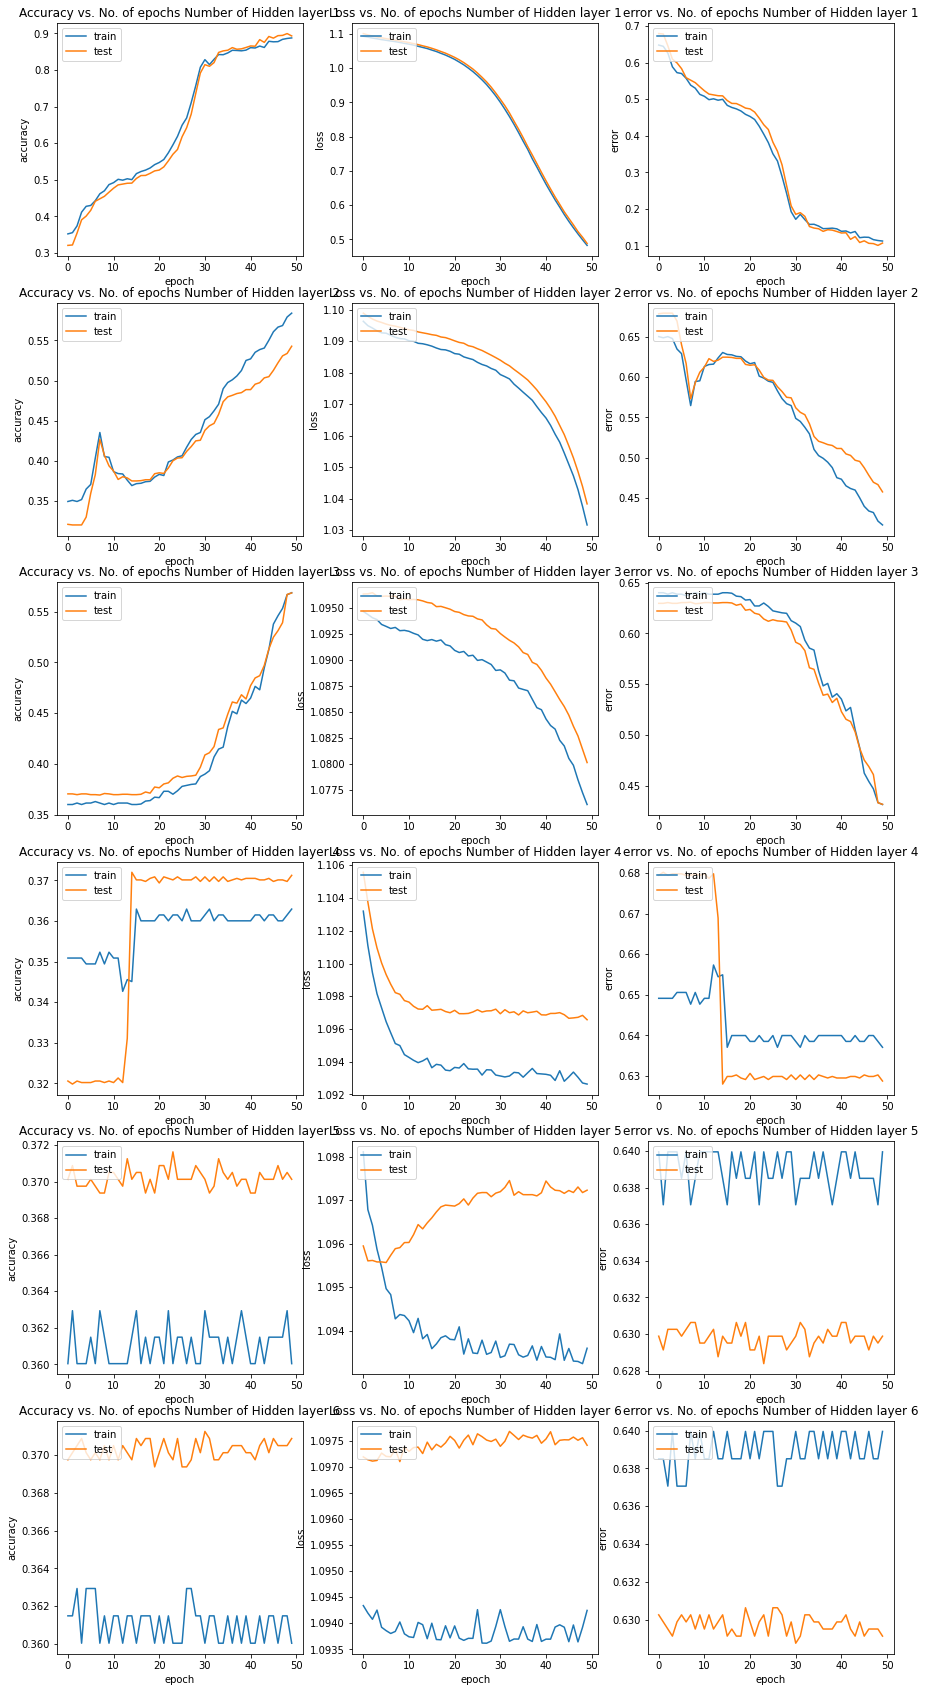

In [28]:
 plot(collections, "Number of Hidden layer ", [1,2,3,4,5,6] )

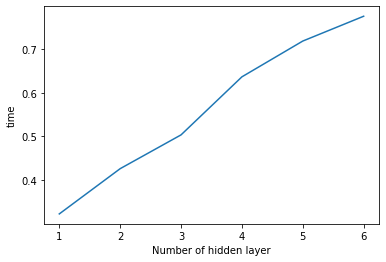

In [29]:
plot_time( [1,2,3,4,5,6] , collections, "Number of hidden layer")

In [30]:
error_statistics("Number of Layer", [1,2,3,4,5,6]  , collections)

,Number of Layer,minimum error,epoch
0,1,0.100601,48
1,2,0.457207,49
2,3,0.431682,49
3,4,0.628003,14
4,5,0.628378,23
5,6,0.628754,30


2 hidden layer seems to provide a better result with lowest error rate after 50 epoch. For this model it seems tha the lower the neuron layer is better.


## Task 3

You are asked to study the effect of learning rates. As with Task 2, your experiments have to be well documented.
You need to give correct conclusion and give suggestion how learning rates should be
set. This includes possible adaptive learning rates where the value increases or decreases as the
increase of epochs.


In [31]:
hidden_size = 64
collections = []
input_size = len(data_train[0])
num_classes = len(np.unique(label))
hidden_list = [nn.Linear(hidden_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
learning_rate = [0.001, 0.005, 0.01 ,0.05, 0.1, 0.5]
average_epoch_time = []

for i in learning_rate :
    model_layer = Model(input_size, hidden_size, hidden_list , out_size = num_classes)
    print(torchinfo.summary(model_layer))
    history_layer = fit(50,i, model_layer)
    average_epoch_time.append(np.mean(history_layer[2]))
    collections.append(history_layer)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            3,136
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       4,160
│    └─Linear: 2-2                       4,160
├─Linear: 1-3                            195
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
Epoch [0], Time 0.394763,
                val_loss: 1.0995, loss: 1.0995,
                val_acc: 0.2492, acc: 0.2577,
                val_err: 0.7508, err: 0.7423,
                
                
Epoch [1], Time 0.450861,
                val_loss: 1.0984, loss: 1.0980,
                val_acc: 0.3251, acc: 0.3412,
                val_err: 0.6749, err: 0.6588,
                
                
Epoch [2], Time 0.494121,
                val_loss: 1.0974, loss: 1.0966,
                val_acc: 0.3146, acc: 0.3137,
                val_err: 0.6854, err: 0.6863,
                
                
Epoch [

Epoch [38], Time 0.490427,
                val_loss: 1.0755, loss: 1.0701,
                val_acc: 0.5184, acc: 0.5574,
                val_err: 0.4816, err: 0.4426,
                
                
Epoch [39], Time 0.463277,
                val_loss: 1.0739, loss: 1.0686,
                val_acc: 0.5188, acc: 0.5574,
                val_err: 0.4812, err: 0.4426,
                
                
Epoch [40], Time 0.468082,
                val_loss: 1.0719, loss: 1.0669,
                val_acc: 0.5094, acc: 0.5550,
                val_err: 0.4906, err: 0.4450,
                
                
Epoch [41], Time 0.476695,
                val_loss: 1.0698, loss: 1.0644,
                val_acc: 0.5068, acc: 0.5458,
                val_err: 0.4932, err: 0.4542,
                
                
Epoch [42], Time 0.432730,
                val_loss: 1.0678, loss: 1.0619,
                val_acc: 0.4947, acc: 0.5270,
                val_err: 0.5053, err: 0.4730,
                
            

Epoch [26], Time 0.595093,
                val_loss: 0.2251, loss: 0.2246,
                val_acc: 0.9234, acc: 0.9208,
                val_err: 0.0766, err: 0.0792,
                
                
Epoch [27], Time 0.742136,
                val_loss: 0.1442, loss: 0.1534,
                val_acc: 0.9399, acc: 0.9295,
                val_err: 0.0601, err: 0.0705,
                
                
Epoch [28], Time 0.533306,
                val_loss: 0.1503, loss: 0.1546,
                val_acc: 0.9448, acc: 0.9358,
                val_err: 0.0552, err: 0.0642,
                
                
Epoch [29], Time 0.498507,
                val_loss: 0.2991, loss: 0.3239,
                val_acc: 0.8330, acc: 0.8229,
                val_err: 0.1670, err: 0.1771,
                
                
Epoch [30], Time 0.522745,
                val_loss: 0.2661, loss: 0.2643,
                val_acc: 0.8893, acc: 0.8866,
                val_err: 0.1107, err: 0.1134,
                
            

Epoch [14], Time 0.471967,
                val_loss: 0.0664, loss: 0.0698,
                val_acc: 0.9741, acc: 0.9730,
                val_err: 0.0259, err: 0.0270,
                
                
Epoch [15], Time 0.480401,
                val_loss: 0.0869, loss: 0.0927,
                val_acc: 0.9561, acc: 0.9561,
                val_err: 0.0439, err: 0.0439,
                
                
Epoch [16], Time 0.504099,
                val_loss: 0.1000, loss: 0.1065,
                val_acc: 0.9550, acc: 0.9479,
                val_err: 0.0450, err: 0.0521,
                
                
Epoch [17], Time 0.473238,
                val_loss: 1.1758, loss: 1.3270,
                val_acc: 0.6888, acc: 0.6593,
                val_err: 0.3112, err: 0.3407,
                
                
Epoch [18], Time 0.493939,
                val_loss: 0.0658, loss: 0.0663,
                val_acc: 0.9707, acc: 0.9677,
                val_err: 0.0293, err: 0.0323,
                
            

Epoch [2], Time 0.456857,
                val_loss: 0.1521, loss: 0.1564,
                val_acc: 0.9426, acc: 0.9368,
                val_err: 0.0574, err: 0.0632,
                
                
Epoch [3], Time 0.478533,
                val_loss: 0.1069, loss: 0.1128,
                val_acc: 0.9640, acc: 0.9599,
                val_err: 0.0360, err: 0.0401,
                
                
Epoch [4], Time 0.470527,
                val_loss: 0.0641, loss: 0.0716,
                val_acc: 0.9820, acc: 0.9802,
                val_err: 0.0180, err: 0.0198,
                
                
Epoch [5], Time 0.461282,
                val_loss: 0.0575, loss: 0.0587,
                val_acc: 0.9685, acc: 0.9701,
                val_err: 0.0315, err: 0.0299,
                
                
Epoch [6], Time 0.445097,
                val_loss: 0.0229, loss: 0.0249,
                val_acc: 1.0000, acc: 0.9995,
                val_err: 0.0000, err: 0.0005,
                
                


Epoch [43], Time 0.456428,
                val_loss: 0.0002, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [44], Time 0.441527,
                val_loss: 0.0002, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [45], Time 0.456171,
                val_loss: 0.0002, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [46], Time 0.468806,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [47], Time 0.492226,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

Epoch [31], Time 0.461465,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [32], Time 0.481452,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [33], Time 0.464613,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [34], Time 0.459185,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [35], Time 0.499205,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

Epoch [19], Time 0.465835,
                val_loss: 1.1095, loss: 1.1125,
                val_acc: 0.3089, acc: 0.2891,
                val_err: 0.6911, err: 0.7109,
                
                
Epoch [20], Time 0.440360,
                val_loss: 1.1095, loss: 1.1045,
                val_acc: 0.3217, acc: 0.3494,
                val_err: 0.6783, err: 0.6506,
                
                
Epoch [21], Time 0.448139,
                val_loss: 1.1102, loss: 1.0995,
                val_acc: 0.3202, acc: 0.3523,
                val_err: 0.6798, err: 0.6477,
                
                
Epoch [22], Time 0.489300,
                val_loss: 1.1037, loss: 1.1125,
                val_acc: 0.3705, acc: 0.3629,
                val_err: 0.6295, err: 0.6371,
                
                
Epoch [23], Time 0.477589,
                val_loss: 1.1041, loss: 1.1126,
                val_acc: 0.3097, acc: 0.2876,
                val_err: 0.6903, err: 0.7124,
                
            

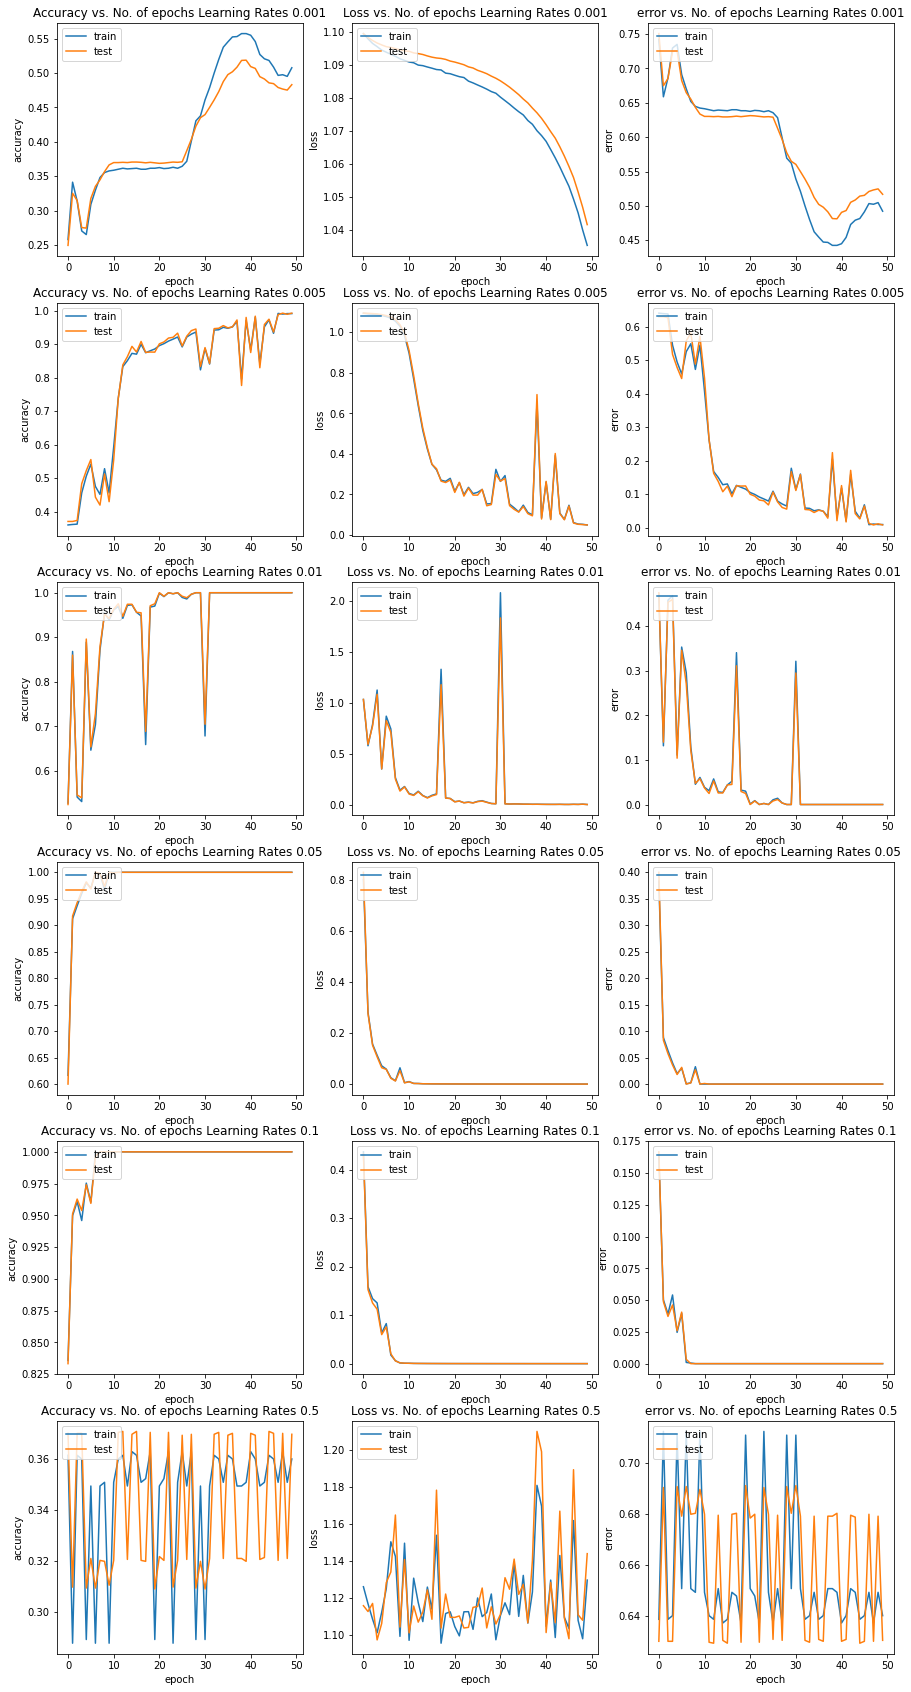

In [32]:
 plot(collections, "Learning Rates ", learning_rate )

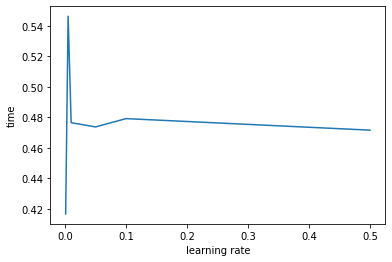

In [33]:
plot_time(learning_rate, collections, "learning rate")

In [34]:
error_statistics("Learning rate", learning_rate , collections)

,Learning rate,minimum error,epoch
0,0.001,0.481231,39
1,0.005,0.007883,47
2,0.010,0.000000,20
3,0.050,0.000000,6
4,0.100,0.000000,7
5,0.500,0.629129,12


Learninig rate of 0.05 seems to provide the best result, with zero error, the time taken for training an epoch seems to be the least as well

## Task 4

You are asked to study the effect of mini-batch size. You can set mini-batch size to be 1 (stochastic
gradient descent), N (batch gradient descent) or any other size. The most important aspect is to be
conclusive with your finding. The mini-batch size really depends on the problem size.

In [35]:
hidden_size = 64
collections = []
input_size = len(data_train[0])
num_classes = len(np.unique(label))
hidden_list = [nn.Linear(hidden_size, hidden_size),nn.Linear(hidden_size, hidden_size)]
learning_rate = 0.05
average_epoch_time = []
batch_size_list = [1,4,8,16,32,64]

for i in  batch_size_list:
    model_layer = Model(input_size, hidden_size, hidden_list , out_size = num_classes)
    print(torchinfo.summary(model_layer))
    history_layer = fit(50,learning_rate,model_layer,batch_size = i)
    average_epoch_time.append(np.mean(history_layer[2]))
    collections.append(history_layer)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            3,136
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       4,160
│    └─Linear: 2-2                       4,160
├─Linear: 1-3                            195
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
Epoch [0], Time 2.175789,
                val_loss: 1.0396, loss: 1.0431,
                val_acc: 0.5926, acc: 0.5862,
                val_err: 0.4074, err: 0.4138,
                
                
Epoch [1], Time 2.104957,
                val_loss: 0.1616, loss: 0.1584,
                val_acc: 0.9503, acc: 0.9434,
                val_err: 0.0497, err: 0.0566,
                
                
Epoch [2], Time 2.105958,
                val_loss: 0.3226, loss: 0.3221,
                val_acc: 0.8510, acc: 0.8466,
                val_err: 0.1490, err: 0.1534,
                
                
Epoch [

Epoch [38], Time 2.133058,
                val_loss: 0.0000, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [39], Time 2.431089,
                val_loss: 0.0000, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [40], Time 2.105764,
                val_loss: 0.0000, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [41], Time 2.798020,
                val_loss: 0.0000, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [42], Time 3.156745,
                val_loss: 0.0000, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

Epoch [26], Time 0.890269,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [27], Time 1.084876,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [28], Time 1.320837,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [29], Time 1.199293,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [30], Time 1.270730,
                val_loss: 0.0001, loss: 0.0001,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

Epoch [14], Time 0.551865,
                val_loss: 0.0005, loss: 0.0005,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [15], Time 0.717825,
                val_loss: 0.0005, loss: 0.0005,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [16], Time 1.119991,
                val_loss: 0.0004, loss: 0.0004,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [17], Time 1.097232,
                val_loss: 0.0005, loss: 0.0004,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [18], Time 1.028129,
                val_loss: 0.0004, loss: 0.0003,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

Epoch [2], Time 0.397003,
                val_loss: 0.7287, loss: 0.7066,
                val_acc: 0.6961, acc: 0.7457,
                val_err: 0.3039, err: 0.2543,
                
                
Epoch [3], Time 0.328259,
                val_loss: 0.1759, loss: 0.1778,
                val_acc: 0.9591, acc: 0.9587,
                val_err: 0.0409, err: 0.0413,
                
                
Epoch [4], Time 0.281378,
                val_loss: 1.3643, loss: 1.1964,
                val_acc: 0.6760, acc: 0.7139,
                val_err: 0.3240, err: 0.2861,
                
                
Epoch [5], Time 0.284003,
                val_loss: 0.0708, loss: 0.0725,
                val_acc: 0.9658, acc: 0.9635,
                val_err: 0.0342, err: 0.0365,
                
                
Epoch [6], Time 0.273144,
                val_loss: 0.1037, loss: 0.1029,
                val_acc: 0.9524, acc: 0.9577,
                val_err: 0.0476, err: 0.0423,
                
                


Epoch [43], Time 0.321669,
                val_loss: 0.0004, loss: 0.0004,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [44], Time 0.294279,
                val_loss: 0.0004, loss: 0.0004,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [45], Time 0.303699,
                val_loss: 0.0004, loss: 0.0003,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [46], Time 0.305207,
                val_loss: 0.0004, loss: 0.0003,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [47], Time 0.297910,
                val_loss: 0.0003, loss: 0.0003,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

Epoch [31], Time 0.180259,
                val_loss: 0.0012, loss: 0.0013,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [32], Time 0.187859,
                val_loss: 0.0015, loss: 0.0017,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [33], Time 0.184227,
                val_loss: 0.0010, loss: 0.0012,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [34], Time 0.165532,
                val_loss: 0.0010, loss: 0.0011,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [35], Time 0.157908,
                val_loss: 0.0010, loss: 0.0011,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

Epoch [19], Time 0.115156,
                val_loss: 0.3173, loss: 0.3591,
                val_acc: 0.8555, acc: 0.8288,
                val_err: 0.1445, err: 0.1712,
                
                
Epoch [20], Time 0.095261,
                val_loss: 0.0530, loss: 0.0597,
                val_acc: 0.9821, acc: 0.9756,
                val_err: 0.0179, err: 0.0244,
                
                
Epoch [21], Time 0.110649,
                val_loss: 0.0425, loss: 0.0473,
                val_acc: 0.9911, acc: 0.9879,
                val_err: 0.0089, err: 0.0121,
                
                
Epoch [22], Time 0.115867,
                val_loss: 0.0370, loss: 0.0407,
                val_acc: 0.9911, acc: 0.9896,
                val_err: 0.0089, err: 0.0104,
                
                
Epoch [23], Time 0.102524,
                val_loss: 0.0270, loss: 0.0288,
                val_acc: 0.9967, acc: 0.9972,
                val_err: 0.0033, err: 0.0028,
                
            

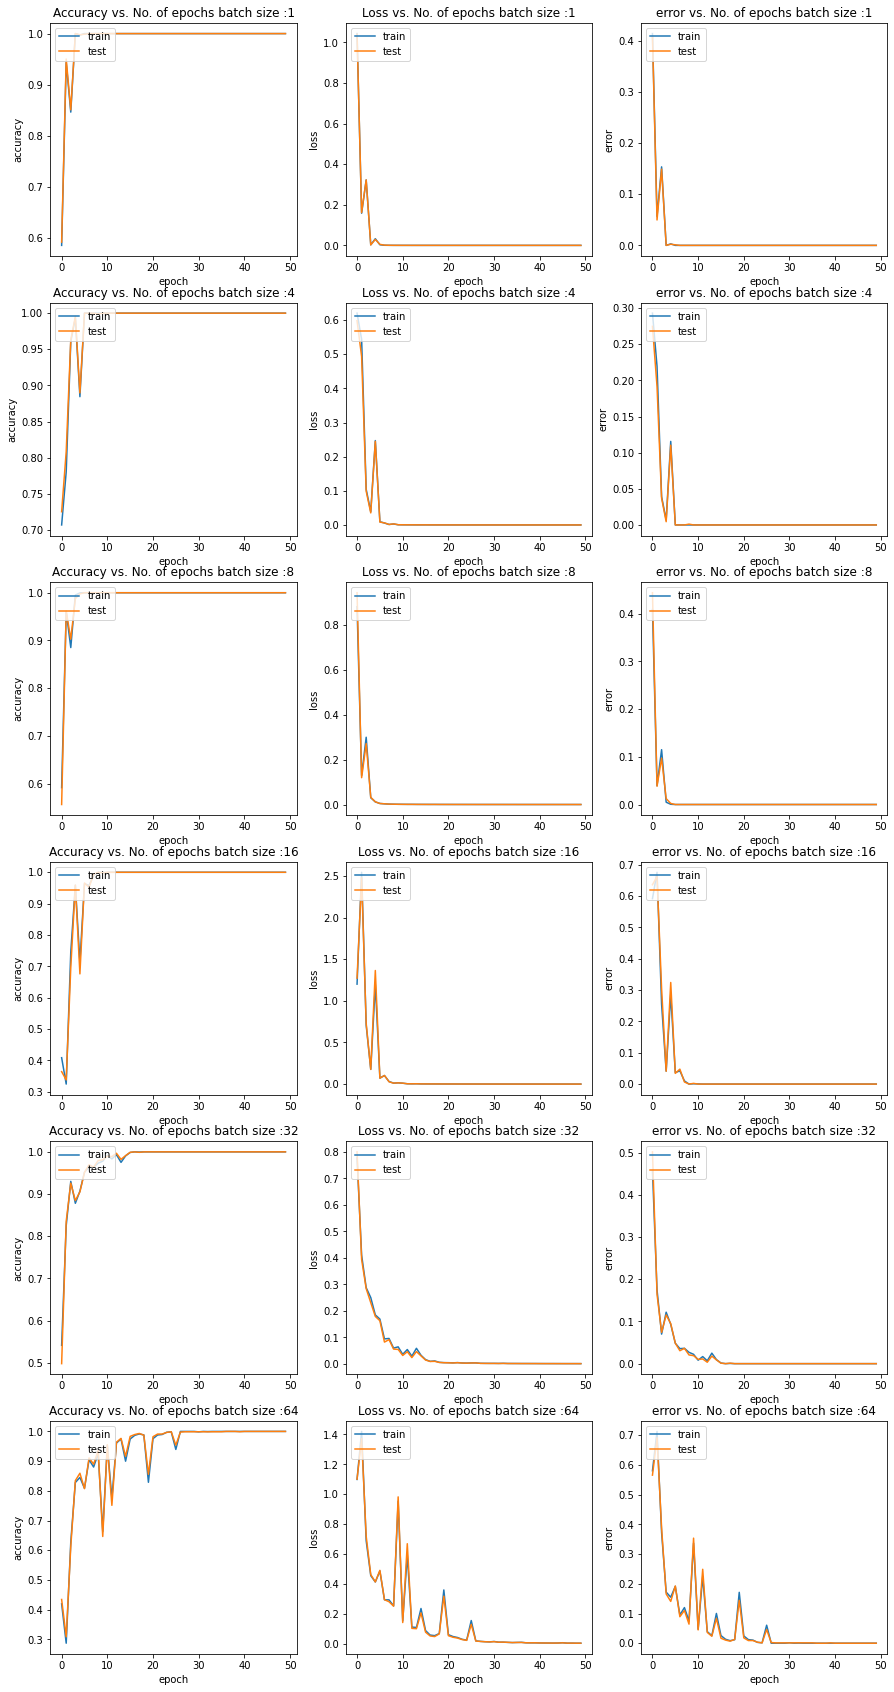

In [36]:
 plot(collections, "batch size :",  batch_size_list )

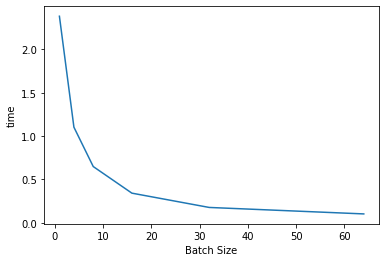

In [37]:
plot_time(batch_size_list, collections, "Batch Size")

In [38]:
error_statistics("Batch Size", batch_size_list , collections)

,Batch Size,minimum error,epoch
0,1,0.0,3
1,4,0.0,5
2,8,0.0,5
3,16,0.0,8
4,32,0.0,16
5,64,0.0,36


## Best Model

In [39]:
hidden_size = 64
collections = []
input_size = len(data_train[0])
num_classes = len(np.unique(label))
hidden_list = [nn.Linear(hidden_size, hidden_size)]
learning_rate = 0.05
average_epoch_time = []
batch = 16

model_layer = Model(input_size, hidden_size, hidden_list , out_size = num_classes)
print(torchinfo.summary(model_layer))
history_layer = fit(50, learning_rate , model_layer, batch_size = batch)
average_epoch_time.append(np.mean(history_layer[2]))
collections.append(history_layer)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Linear: 1-1                            3,136
├─ModuleList: 1-2                        --
│    └─Linear: 2-1                       4,160
├─Linear: 1-3                            195
Total params: 7,491
Trainable params: 7,491
Non-trainable params: 0
Epoch [0], Time 1.958392,
                val_loss: 0.1528, loss: 0.1588,
                val_acc: 0.9233, acc: 0.9293,
                val_err: 0.0767, err: 0.0707,
                
                
Epoch [1], Time 1.826539,
                val_loss: 0.2068, loss: 0.2284,
                val_acc: 0.9323, acc: 0.9182,
                val_err: 0.0677, err: 0.0818,
                
                
Epoch [2], Time 1.835548,
                val_loss: 0.7168, loss: 0.6815,
                val_acc: 0.7991, acc: 0.8098,
                val_err: 0.2009, err: 0.1902,
                
                
Epoch [3], Time 1.800077,
                val_loss: 0.00

Epoch [38], Time 1.930806,
                val_loss: 0.0001, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [39], Time 1.890342,
                val_loss: 0.0001, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [40], Time 1.876308,
                val_loss: 0.0001, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [41], Time 2.006718,
                val_loss: 0.0000, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
                
Epoch [42], Time 1.913103,
                val_loss: 0.0000, loss: 0.0000,
                val_acc: 1.0000, acc: 1.0000,
                val_err: 0.0000, err: 0.0000,
                
            

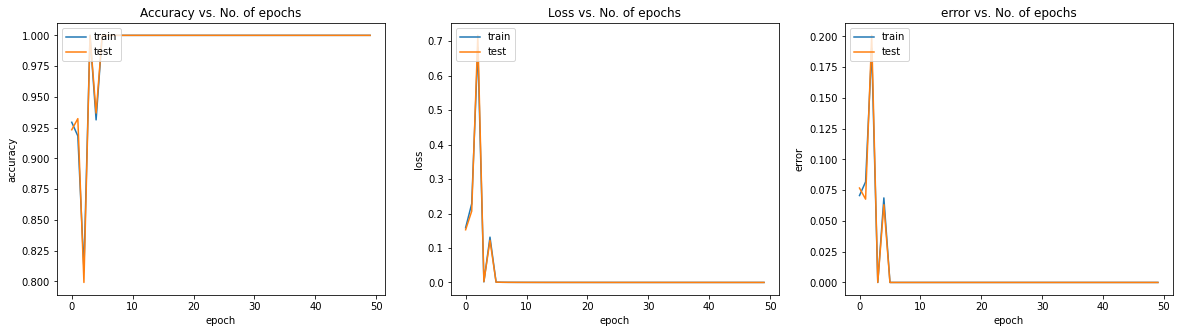

In [40]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 3, figsize=(20,5))



val_history = history_layer[0]
train_history = history_layer[1]

val_accuracies = [result['val_acc'] for result in val_history ]
train_accuracies = [result['val_acc'] for result in train_history]

axes[0].plot(train_accuracies, label='Train')
axes[0].plot(val_accuracies, label='Test')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].set_title('Accuracy vs. No. of epochs')
axes[0].legend(['train', 'test'], loc='upper left')


val_loss = [result['val_loss'] for result in val_history ]
train_loss = [result['val_loss'] for result in train_history]

axes[1].plot(train_loss, label='Train')
axes[1].plot(val_loss, label='Test')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].set_title('Loss vs. No. of epochs')
axes[1].legend(['train', 'test'], loc='upper left')

val_error = [result['val_error'] for result in val_history ]
train_error = [result['val_error'] for result in train_history]

axes[2].plot(train_error, label='Train')
axes[2].plot(val_error, label='Test')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('error')
axes[2].set_title('error vs. No. of epochs')
axes[2].legend(['train', 'test'], loc='upper left')